In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
import plotly.express as px
from dotenv import load_dotenv
import json
from collections import defaultdict
import importlib
import warnings
warnings.filterwarnings('ignore')
import utils
importlib.reload(utils)
import os
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from scipy.optimize import differential_evolution, curve_fit
from scipy.stats import skewnorm, norm

In [204]:
def load_weather(weather_path, obs_year):    
    # Load the "Hourly" weather data
    
    weather_data = pd.read_csv(weather_path)
    # Slicing the weather data to the dates within the observation year
    weather_data['Date'] = pd.to_datetime(weather_data['Date'], errors='coerce')
    weather_data = weather_data[
        (weather_data['Date'] >= pd.to_datetime(f'1/1/{obs_year}')) &
        (weather_data['Date'] <= pd.to_datetime(f'31/12/{obs_year}'))]     
    # Renaming the columns and add doy column         
    weather_data = weather_data[['Date', 'Time', 'Air Temp. (°C)']].rename(columns={'Date': 'date', 'Time':'Time', 'Air Temp. (°C)':'temp'}, inplace=False)
    weather_data.insert(1, 'doy', [d.dayofyear for d in pd.to_datetime(weather_data['date'], format="mixed")])
    # Interpolate missing values
    # Convert '-' to NaN
    weather_data['temp'].replace('-', np.nan, inplace=True)
    weather_data['temp']=weather_data['temp'].apply(pd.to_numeric, errors='coerce')

    # Interpolate missing values
    if weather_data['temp'].isna().any():
        weather_data['temp'].interpolate(method='linear', inplace=True)


    return weather_data.reset_index(drop=True) 


In [209]:
# Load datasets for observations
def load_observations(file_path,BB_sheet_name, Flwr_sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location, excel_observs_BB, excel_observs_Flwr, spray_col_name):
    
    # Define the expected column names for the final concatenated DataFrame
    TREATMENT = "Treatment"
    LOCATION = "Location"
    xls = pd.ExcelFile(file_path, engine="openpyxl")
    raw_df_BB = pd.read_excel(xls, sheet_name = BB_sheet_name)
    raw_df_Flwr = pd.read_excel(xls, sheet_name = Flwr_sheet_name)

    # Rename the Dates to Days of Year (DOY)
    doy_column_BB = [pd.to_datetime(col).dayofyear for col in raw_df_BB.columns if utils.is_date_column(col)]
    df_BB = raw_df_BB.rename(columns={col:pd.to_datetime(col).dayofyear for col in raw_df_BB.columns if utils.is_date_column(col)})

    doy_column_Flwr = [pd.to_datetime(col).dayofyear for col in raw_df_Flwr.columns if utils.is_date_column(col)]
    df_Flwr = raw_df_Flwr.rename(columns={col:pd.to_datetime(col).dayofyear for col in raw_df_Flwr.columns if utils.is_date_column(col)})

    obs_year = [pd.to_datetime(col).year for col in raw_df_BB.columns if utils.is_date_column(col)][0]


    # Apply filtering for the given cultivar & treatments
    def filter_df(df, doy_column, spray_col_name):
        filtered_df = df[df[cultivar_col].isin([cultivar_name]) & df[treatment_col].isin([treatment_name])]
        # Rename columns
        columns_to_select = [treatment_col] + [spray_col_name] + doy_column 
        filtered_df = filtered_df[columns_to_select]
        filtered_df.rename(columns={treatment_col: TREATMENT}, inplace=True)
        # Add the LOCATION column to the DataFrame
        filtered_df[LOCATION] = location
        # Remove rows with any NaN values
        filtered_df = filtered_df.dropna()
        # Reset index 
        filtered_df.reset_index(drop=True)
        return filtered_df
    filtered_df_BB = filter_df(df_BB,doy_column_BB, spray_col_name)

    filtered_df_Flwr = filter_df(df_Flwr,doy_column_Flwr, spray_col_name)

    # Spray date(s)
    application_dates = filtered_df_BB[spray_col_name].unique()

    BudBurstDOYs = []
    FlwrDOYs = []
    for spray_date in application_dates:
        # find the budburst doy for each application date
        filtered_df_BB_spray = filtered_df_BB[filtered_df_BB[spray_col_name].isin([spray_date])]
        BB_percent = False
        PBB, BB, BudBurstDOY, max_observed_buds = utils.BB_specifications(location,filtered_df_BB_spray[doy_column_BB],BB_percent)
        BudBurstDOYs.append(int(BudBurstDOY))
        maxBBPsequence = np.empty(len(doy_column_BB))*np.nan
        maxBBPsequence[-1] = np.max(PBB)

        # Corresponding stage name (StartFlowering) to get the max BBP 
        MaxBBPstageSequence = [np.nan for i in range(len(doy_column_BB))]
        MaxBBPstageSequence[-1] = 'StartFlowering'


        # Generate the observations Excel file for Budbreak
        excel_observ_BB = pd.DataFrame(data={
        'SimulationName': f'{BB_sheet_name}{filtered_df_BB_spray[TREATMENT].iloc[0].replace(" ", "")}{pd.to_datetime(spray_date).day_of_year}', 
                                            'Clock.Today': [col for col in raw_df_BB.columns if utils.is_date_column(col)],
                                            'Clock.Today.Year': obs_year,
                                            'DOY': doy_column_BB, 
                                            LOCATION: filtered_df_BB_spray[LOCATION].iloc[0], 
                                            TREATMENT: filtered_df_BB_spray[TREATMENT].iloc[0],
                                            'KiwiFruit.Phenology.BrokenBuds': BB,
                                            'KiwiFruit.Phenology.ProportionBB': PBB,
                                            'KiwiFruit.Phenology.BudBurstDOY': BudBurstDOY,
                                            'KiwiFruit.Phenology.MaxBBP': maxBBPsequence,
                                            'KiwiFruit.Phenology.CurrentStageName': MaxBBPstageSequence})
        
        FlwrDOY, Flowers = utils.Flwr_specifications(np.max(BB),filtered_df_Flwr[doy_column_Flwr])
        FlwrDOYs.append(int(FlwrDOY))
        maxFlwrsequence = np.empty(len(doy_column_Flwr))*np.nan
        maxFlwrsequence[-1] = FlwrDOY

        # Corresponding stage name (StartFlowering) to get the max BBP 
        MaxFlwrstageSequence = [np.nan for i in range(len(doy_column_Flwr))]
        MaxFlwrstageSequence[-1] = 'StartFlowering'

        # Generate the observations Excel file for Flowering
        excel_observ_Flwr = pd.DataFrame(data={
        'SimulationName': f'{BB_sheet_name}{filtered_df_BB[TREATMENT].iloc[0].replace(" ", "")}{pd.to_datetime(spray_date).day_of_year}',  # Use same BB sheet name to be able to put in same apsim simulation
                                            'Clock.Today': [col for col in raw_df_Flwr.columns if utils.is_date_column(col)],
                                            'Clock.Today.Year': obs_year,
                                            'DOY': doy_column_Flwr, 
                                            LOCATION: filtered_df_Flwr[LOCATION].iloc[0], 
                                            TREATMENT: filtered_df_Flwr[TREATMENT].iloc[0],
                                            'KiwiFruit.Phenology.Flowers': Flowers,
                                            'KiwiFruit.Phenology.FloweringDOY': FlwrDOY,
                                            'KiwiFruit.Phenology.CurrentStageName': MaxFlwrstageSequence})
        
        excel_observs_BB.append(excel_observ_BB)
        excel_observs_Flwr.append(excel_observ_Flwr)

    return obs_year, application_dates, PBB, BB, BudBurstDOYs, FlwrDOYs, excel_observs_BB, excel_observs_Flwr
    


In [380]:
with open("config_MultiDataFiles_HC.json", "r") as file:
    config = json.load(file)
base_model_config = utils.base_model_config()
start_doy = pd.to_datetime(base_model_config["StartDay"]).dayofyear

predicted_endo_release_doy = defaultdict(lambda: defaultdict(lambda: dict()))
predicted_budbreak_doy = defaultdict(lambda: defaultdict(lambda: dict()))
observed_budbreak_doy = defaultdict(lambda: defaultdict(lambda: dict()))
predicted_flowering_doy = defaultdict(lambda: defaultdict(lambda: dict()))
observed_flowering_doy = defaultdict(lambda: defaultdict(lambda: dict()))
observed_application_doy = defaultdict(lambda: defaultdict(lambda: dict()))
weather_df = defaultdict(lambda: defaultdict(lambda: dict()))
excel_observs_BB = []
excel_observs_Flwr = []
output_excel = 'HC_Observations.xlsx'

# Load environment variables
load_dotenv()
FOLDER_PATH = os.getenv('FOLDER_PATH')
for file_name, file_info in config.items():
        file_path = os.path.join(FOLDER_PATH, file_name)
        # Process each sheet
        for sheet_info in file_info['sheets']:
            # Extract sheet names, cultivars, and treatments
            BB_sheet_name = sheet_info['BB_sheet_name']
            Flwr_sheet_name = sheet_info['Flwr_sheet_name']
            location = sheet_info['location']
            spray_col_name = sheet_info['spray']
            cultivar_col, cultivar_name = list(sheet_info['cultivar'].items())[0]
            treatment_col, treatment_name = list(sheet_info['treatments'].items())[0]

            # Load and calculate the observed budburst doy
            obs_year, application_dates, PBB, BB, BudBurstDOYs, Flwr_DOYs, excel_observs_BB, excel_observs_Flwr  = load_observations(file_path,BB_sheet_name, Flwr_sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location,excel_observs_BB, excel_observs_Flwr,spray_col_name)
            for spray_date,BudBurstDOY,Flwr_DOY in zip(application_dates,BudBurstDOYs,Flwr_DOYs):
                observed_budbreak_doy[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = BudBurstDOY
                observed_flowering_doy[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = Flwr_DOY
                observed_application_doy[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = pd.to_datetime(spray_date).dayofyear

                # Load and store the weather data
                weather_path = sheet_info['weather_path']
                weather_data = load_weather(weather_path, obs_year)
                weather_df[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = weather_data


excel_observs_BB_df = pd.concat(excel_observs_BB, ignore_index=True, sort=False)
excel_observs_Flwr_df = pd.concat(excel_observs_Flwr, ignore_index=True, sort=False)

with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
    excel_observs_BB_df.to_excel(writer, sheet_name='BB-HC', index=False)
    excel_observs_Flwr_df.to_excel(writer, sheet_name='Flwr-HC', index=False)

In [381]:
def Chill(Tc, T):
    if T>=0 and T <= Tc:
        return (((4*T)/(Tc**2))*(Tc-T))
    else:
        return 0
    
def Wangengel(MinTemp,OptTemp,MaxTemp,RefTemp,T):
    RelEff = 0.0
    RelEffRefTemp = 1.0
    p = 0.0

    if MinTemp < T < MaxTemp:
        p = math.log(2.0) / math.log((MaxTemp - MinTemp) / (OptTemp - MinTemp))
        RelEff = (2 * (T - MinTemp) ** p * (OptTemp - MinTemp) ** p - (T - MinTemp) ** (2 * p)) / (OptTemp - MinTemp) ** (2 * p)

    if MinTemp < RefTemp < MaxTemp:
        p = math.log(2.0) / math.log((MaxTemp - MinTemp) / (OptTemp - MinTemp))
        RelEffRefTemp = (2 * (RefTemp - MinTemp) ** p * (OptTemp - MinTemp) ** p - (RefTemp - MinTemp) ** (2 * p)) / (OptTemp - MinTemp) ** (2 * p)

    return float(RelEff / RelEffRefTemp)

# Budbreak prediction 
def budbreak_prediction(weather_since_start_doy, chill_target, heat_target):
    chillVal = 0
    for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
        chillVal += Chill( base_model_config['Tc_chill'], temp)
        if chillVal >= chill_target:
            break

    # Heat accumulation
    # from the date of endodormancy release, start accumulating heat
    heatVal = 0
    for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
        heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)
        if heatVal >= heat_target:
            predicted_doy = int(weather_since_start_doy['doy'].iloc[idx_endodormancy_release + idx_bb + 1])
            break
    return predicted_doy

def logistic_scaling(app_units, ideal_units,max_effect_low, max_effect_high, steepness):
    distance = app_units - ideal_units
    scale = 1 / (1 + np.exp(-steepness * distance))
    max_effect = max_effect_low + scale * (max_effect_high - max_effect_low)
    return max_effect

def linear_scaling(app_units, ideal_units, max_effect_high, max_effect_low,  tolerance):
    # Linear scaling of max_effect depending on distance from ideal_doy
    distance = abs(app_units - ideal_units)
    scale = min(distance / tolerance, 1)  # cap at 1 to avoid over-scaling
    max_effect = max_effect_low + scale * (max_effect_high - max_effect_low)
    return max_effect

def quadratic_scaling(app_units, ideal_units, max_effect_high, max_effect_low,  tolerance):
    # Linear scaling of max_effect depending on distance from ideal_doy
    distance = abs(app_units - ideal_units)
    scale = min(distance / tolerance, 1) ** 2 # cap at 1 to avoid over-scaling
    max_effect = max_effect_low + scale * (max_effect_high - max_effect_low)
    return max_effect

def hi_cane_effective_chill_target(ideal_units, max_effect, tolerance, app_units, base_chill_target):
    """
    Adjusts effective chill target based on timing of Hi-Cane application and 
    a linearly scaled max effect that varies with application units (app_units) relative to ideal window.
    
    Parameters:
    - ideal_units: target accumulated units where Hi-Cane is most effective
    - max_effect_high: effect when applied far from ideal (e.g. early/late)
    - max_effect_low: effect when applied near the ideal time
    - tolerance: spread of the Gaussian curve
    - app_units: accumulated chill units at application
    - base_chill_target: baseline chill requirement without Hi-Cane
        
    Returns:
        adjusted chill target based on application timing
    """
    Gaussian = max_effect * np.exp(-0.5 * ((app_units - ideal_units) / tolerance) ** 2)

    # linear scaling:
    # max_effect = quadratic_scaling(app_units, ideal_units, max_effect_high, max_effect_low, tolerance)

    effect = 1 - Gaussian

    effective_chill_target = base_chill_target * effect

    return effective_chill_target

def hi_cane_effective_heat_target(ideal_units, max_effect, steepness, app_units, base_heat_target):
    Logistic = -max_effect/(1 + np.exp(-steepness*(app_units - ideal_units)))

    effect = 1 - Logistic

    effective_heat_target = base_heat_target * effect

    return effective_heat_target

def skewed_gaussian_effect(Acc_unit_spray, max_effect, center, width, skew, base_chill_target):
    skewed_Guassian =  skewnorm.pdf(Acc_unit_spray - center, a=skew, scale=width) 
    effect = 1 - max_effect * skewed_Guassian
    effective_chill_target = base_chill_target * effect

    return effective_chill_target


# Calculate Acc. Chill units on Spray Date

In [382]:
CHU_spray = defaultdict(lambda: defaultdict(lambda: dict()))
CHU_observation = defaultdict(lambda: defaultdict(lambda: dict()))


start_day = int(round(pd.to_datetime(utils.base_model_config()['StartDay']).day_of_year))

for location in observed_application_doy.keys():
    for year in observed_application_doy[location].keys():
        for sheet_info, weather_data in weather_df[location][year].items():
            application_doy = observed_application_doy[location][year][sheet_info]
            observation_doy = observed_budbreak_doy[location][year][sheet_info]
            weather_since_start_doy = weather_data[weather_data['doy']>=start_day].reset_index(drop=True)  
            
            # Chill & heat accumulation on Spray Date
            chillVal = 0
            heatVal = 0
            for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
                chillVal += Chill( base_model_config['Tc_chill'], temp)
                if (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] == application_doy and chillVal < base_model_config['ChillRequirement']):
                    CHU_spray[location][year][sheet_info] = chillVal    
                    break 
                elif (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] < application_doy and chillVal >= base_model_config['ChillRequirement']):
                    break 
            # if (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] < application_doy and chillVal >= base_model_config['ChillRequirement']):
            for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
                heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)                       
                if weather_since_start_doy['doy'].iloc[idx_bb+idx_endodormancy_release+1] == application_doy: # count all the heat units even if it's over the heat target (to account for even after BB spraying)                       
                    CHU_spray[location][year][sheet_info] = chillVal + heatVal
                    break 

            # print(CHU_spray[location][year][sheet_info])
            # Chill & heat accumulation on Observation Date
            chillVal = 0
            heatVal = 0
            for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
                    chillVal += Chill( base_model_config['Tc_chill'], temp)
                    if (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] == observation_doy and chillVal < base_model_config['ChillRequirement']):
                        CHU_observation[location][year][sheet_info] = chillVal    
                        break 
                    elif (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] < observation_doy and chillVal >= base_model_config['ChillRequirement']):
                        break 
            # if (weather_since_start_doy['doy'].iloc[idx_endodormancy_release] < observation_doy and chillVal >= base_model_config['ChillRequirement']):
            for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
                heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)                       
                if weather_since_start_doy['doy'].iloc[idx_bb+idx_endodormancy_release+1] == observation_doy: # count all the heat units even if it's over the heat target (to account for even after BB spraying)                       
                    CHU_observation[location][year][sheet_info] = chillVal + heatVal
                    break 
            # print(CHU_observation[location][year][sheet_info])


In [383]:
observations = []
predictions = []
spray_doys = []
chu_obs = []
chu_spray = []
natural = []

for loc in observed_budbreak_doy.keys():
     for year in observed_budbreak_doy[loc].keys():
            for sheet_info in observed_budbreak_doy[loc][year]:
                observed_bb = observed_budbreak_doy[loc][year][sheet_info]
                observations.append(observed_bb)
                # predicted_bb = predicted_budbreak_doy[loc][year][sheet_info]
                # predictions.append(predicted_bb)

                spray_doys.append(observed_application_doy[loc][year][sheet_info])
                chu_obs.append(CHU_observation[loc][year][sheet_info])
                chu_spray.append(CHU_spray[loc][year][sheet_info])
                # natural.append(natural_budbreak_doy[loc][year][sheet_info])


# mae = utils.mean_absolute_error(observations,predictions)
# plt.scatter(x=observations,y=predictions)
# plt.plot(np.arange(240,290,1), np.arange(240,290,1), 'k--')
# plt.xlabel('Observed BB DOY')
# plt.ylabel('Predicted BB DOY')
# plt.title(f'MAE = {round(mae,2)}')
# plt.grid()


# Gaussian + Logistic

In [ ]:
CU_eco_start = 1689.30
normal_budbreak = 1689.30 + 101.29
def hi_cane_combined_model(CU, CU_opt, A, sigma, B, k):
    """
    Combined Hi-Cane response:
    - Gaussian (positive) during endodormancy
    - Logistic (negative) during ecodormancy
    """
    CU = np.array(CU)
    
    gaussian = A * np.exp(-((CU - CU_opt) ** 2) / (2 * sigma ** 2))
    logistic = -B / (1 + np.exp(-k * (CU - CU_eco_start)))

    
    # Only apply logistic penalty after eco-dormancy begins
    effect =  np.where(CU <= CU_eco_start, gaussian, gaussian+logistic)
    
    return effect



# Filter data to remove post endo-dormancy HC applications
chu_spray = np.array(chu_spray)
chu_obs = np.array(chu_obs)
filter_post_endo = (chu_spray <= CU_eco_start) & (chu_obs < normal_budbreak)

x = chu_spray[filter_post_endo]
y = np.array(normal_budbreak)-chu_obs[filter_post_endo]

# Initial guess: [CU_opt, A, sigma]
p0 = [1300, 170, 100]

# Parameter bounds to help constrain and ensure both phases get fit
bounds = (
    [1200, 50, 50],  # Lower bounds
    [1400, 200, 200]  # Upper bounds
)

# Fit the model
popt, _ = curve_fit(hi_cane_combined_model, x, y, p0=p0, bounds=bounds, maxfev=10000)

# Generate fit curve
x_fit = np.linspace(min(x)-50, max(x)+50, 300)
y_fit = hi_cane_combined_model(x_fit, *popt)

# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(x, y, label="Observed", color="blue")
plt.plot(x_fit, y_fit, label="Fitted Model", color="darkred", linewidth=2)
plt.axvline(CU_eco_start, linestyle='--', color='m', label="Ecodormancy start")
plt.axvline(normal_budbreak, linestyle='--', color='green', label="Normal budbreak")
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Chill Units at Spray")
plt.ylabel("Hi-Cane Effectiveness")
plt.title("Hi-Cane Effect Model (Gaussian)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print fitted parameter values
param_names = ["CU_opt", "A", "sigma"]
for name, val in zip(param_names, popt):
    print(f"{name}: {val:.2f}")



# Skewed Gaussian (Chill-oriented)

In [ ]:
chill_requirement = 1689.30
heat_requirement = 101.29
normal_budbreak = chill_requirement + heat_requirement

def skewed_gaussian(x, mu, A, sigma, alpha):
    """
    Skewed Gaussian: combines a normal PDF and CDF
    """
    norm_pdf = norm.pdf((x - mu) / sigma)
    norm_cdf = norm.cdf(alpha * (x - mu) / sigma)
    return A * 2 * norm_pdf * norm_cdf


# Filter data to remove post endo-dormancy HC applications
filter_post_endo = (chu_spray <= chill_requirement)

chu_spray = np.array(chu_spray)

chu_obs = np.array(chu_obs)

x = chu_spray[filter_post_endo]
y = (np.array(chill_requirement)-(chu_obs[filter_post_endo]-heat_requirement))/chill_requirement

# Initial guess: [mu, A, sigma, alpha]
p0 = [1300, 0.2, 100, 5]

# Parameter bounds to help constrain and ensure both phases get fit
bounds = (
    [1000, 0.13, 50, 0],  # Lower bounds
    [1400, 0.5, 300, 20]  # Upper bounds
)

# Fit the model
popt, _ = curve_fit(skewed_gaussian, x, y, p0=p0, bounds=bounds, maxfev=10000)

# Generate fit curve
x_fit = np.linspace(min(x)-300, max(x)+200, 300)
y_fit = skewed_gaussian(x_fit, *popt)

# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(x, y, label="Observed", color="blue")
plt.plot(x_fit, y_fit, label="Fitted Model", color="darkred", linewidth=2)
plt.axvline(chill_requirement, linestyle='--', color='m', label="Ecodormancy start")
plt.axvline(normal_budbreak, linestyle='--', color='green', label="Normal budbreak")
plt.axvline(1383, linestyle='--', color='c', label="HWBBRawTP2021HiCane214")
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Chill Units at Spray")
plt.ylabel("Hi-Cane Effectiveness")
plt.title("Hi-Cane Effect Model (Skewed Gaussian)")
bbox = dict(boxstyle="round", fc="0.8")
plt.annotate(
    f'max = ({x_fit[np.argmax(y_fit)]:.0f}, {np.max(y_fit):.2f})',
    xy=(popt[0]-70, np.max(y_fit)), 
    bbox=bbox)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print fitted parameter values
param_names = ["mu", "A", "sigma", "alpha"]
for name, val in zip(param_names, popt):
    print(f"{name}: {val:.2f}")



# Skewed Gaussian (Chill+Heat)

In [ ]:
chill_requirement = 1689.30
heat_requirement = 101.29
normal_budbreak = chill_requirement + heat_requirement

def skewed_gaussian(x, mu, A, sigma, alpha):
    """
    Skewed Gaussian: combines a normal PDF and CDF
    """
    norm_pdf = norm.pdf((x - mu) / sigma)
    norm_cdf = norm.cdf(alpha * (x - mu) / sigma)
    return A * 2 * norm_pdf * norm_cdf


# Filter data to remove post endo-dormancy HC applications
filter_post_endo = (chu_spray <= chill_requirement)

chu_spray = np.array(chu_spray)

chu_obs = np.array(chu_obs)

x = chu_spray[filter_post_endo]
y = (np.array(normal_budbreak)-(chu_obs[filter_post_endo]))/normal_budbreak

# Initial guess: [mu, A, sigma, alpha]
p0 = [1300, 0.2, 100, 5]

# Parameter bounds to help constrain and ensure both phases get fit
bounds = (
    [900, 0.13, 50, 0],  # Lower bounds
    [1400, 0.5, 300, 20]  # Upper bounds
)

# Fit the model
popt, _ = curve_fit(skewed_gaussian, x, y, p0=p0, bounds=bounds, maxfev=10000)

# Generate fit curve
x_fit = np.linspace(min(x)-700, max(x)+200, 300)
y_fit = skewed_gaussian(x_fit, *popt)

# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(x, y, label="Observed", color="blue")
plt.plot(x_fit, y_fit, label="Fitted Model", color="darkred", linewidth=2)
plt.axvline(chill_requirement, linestyle='--', color='m', label="Ecodormancy start")
plt.axvline(normal_budbreak, linestyle='--', color='green', label="Normal budbreak")
plt.axvline(1383, linestyle='--', color='c', label="HWBBRawTP2021HiCane214")
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Chill Units at Spray")
plt.ylabel("Hi-Cane Effectiveness")
plt.title("Hi-Cane Effect Model (Skewed Gaussian)")
bbox = dict(boxstyle="round", fc="0.8")
plt.annotate(
    f'max = ({x_fit[np.argmax(y_fit)]:.0f}, {np.max(y_fit):.2f})',
    xy=(popt[0]-70, np.max(y_fit)), 
    bbox=bbox)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print fitted parameter values
param_names = ["mu", "A", "sigma", "alpha"]
for name, val in zip(param_names, popt):
    print(f"{name}: {val:.2f}")



In [201]:
locations = ['Te Puke', 'Kerikeri']
chill_start_day = pd.to_datetime(utils.base_model_config()['StartDay']).day_of_year 
ideal_units_gaussian = popt[0]
max_effect_gaussian = popt[1]
tolerance_gaussian = popt[2]
skew_gaussian = popt[3]

predicted_budbreak_doy = defaultdict(lambda: defaultdict(lambda: defaultdict()))
natural_budbreak_doy = defaultdict(lambda: defaultdict(lambda: defaultdict()))

for i, location in enumerate(locations):
    start_day = int(round(chill_start_day))
    for year, sheet_info in weather_df[location].items(): 
        for sheet_info, weather_data in weather_df[location][year].items():
            weather_since_start_doy = weather_data[weather_data['doy']>=start_day].reset_index(drop=True)  
            
            Acc_unit_spray = CHU_spray[location][year][sheet_info]

            effective_budbreak_target = 1 - skewed_gaussian(Acc_unit_spray, ideal_units_gaussian, max_effect_gaussian,tolerance_gaussian,skew_gaussian)
            effective_chill_target = base_model_config['ChillRequirement'] * effective_budbreak_target*1.02
            effective_heat_target = base_model_config['HeatRequirement'] * effective_budbreak_target*0.61
            
            
            predicted_doy = budbreak_prediction(weather_since_start_doy, effective_chill_target, effective_heat_target)
            natural_budbreak = budbreak_prediction(weather_since_start_doy, base_model_config['ChillRequirement'], base_model_config['HeatRequirement'])



            predicted_budbreak_doy[location][year][sheet_info] = predicted_doy
            natural_budbreak_doy[location][year][sheet_info] = natural_budbreak
            

In [ ]:
def observ_predict_plot(predicted_budbreak_doy, observed_budbreak_doy, CHU_spray, natural_budbreak_doy, regression_xy=False):
    fig = go.Figure()

    observations = []
    predictions = []
    all_bb_days = []
    for loc in observed_budbreak_doy.keys():
        for year in observed_budbreak_doy[loc].keys():
            for sheet_info in observed_budbreak_doy[loc][year]:
                Acc_unit_spray = CHU_spray[loc][year][sheet_info]
                observed_bb = observed_budbreak_doy[loc][year][sheet_info]
                predicted_bb = predicted_budbreak_doy[loc][year][sheet_info]
                natural_bb = natural_budbreak_doy[loc][year][sheet_info]
                if Acc_unit_spray < base_model_config['ChillRequirement'] and predicted_bb < natural_bb:
                    observations.append(observed_bb)
                    
                    predictions.append(predicted_bb)

                    all_bb_days.append(observed_bb)
                    all_bb_days.append(predicted_bb)

                    fig.add_trace(go.Scatter(x=[observed_bb], y=[predicted_bb], mode='markers', marker=dict(size=15), name=sheet_info))
                else:
                    continue

    mae = round(utils.mean_absolute_error(observations,predictions),2)
    rmse = round(root_mean_squared_error(observations,predictions),2)


    # Add 1:1 dashed line
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=[min(all_bb_days), max(all_bb_days)], mode='lines', line=dict(color="white", dash="dash"), name="1:1 Line")) 

    # Calculate std of observations to compare with MAE
    obs_std = round(np.std(observations),2)
    # ±MAE bands
    upper_line_mae = np.array([min(all_bb_days), max(all_bb_days)]) + np.array(mae)   
    lower_line_mae = np.array([min(all_bb_days), max(all_bb_days)]) - np.array(mae)  
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=upper_line_mae, mode='lines', line=dict(color="grey", dash="dot"), name='+MAE'))
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=lower_line_mae, mode='lines', line=dict(color="grey", dash="dot"), name='-MAE'))  
    # RMSE bands: If RMSE bands are much wider than MAE bands, it means there are large outliers affecting the model's performance.
    upper_line_rmse = np.array([min(all_bb_days), max(all_bb_days)]) + np.array(mae)   
    lower_line_rmse = np.array([min(all_bb_days), max(all_bb_days)]) - np.array(mae)  
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=upper_line_rmse, mode='lines', line=dict(color="yellow", dash="dot"), name='+RMSE'))
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=lower_line_rmse, mode='lines', line=dict(color="yellow", dash="dot"), name='-RMSE'))  

    # Plot regression line
    if regression_xy is not False:
        fig.add_trace(go.Scatter(x=regression_xy[0], y=regression_xy[1], mode='lines', line=dict(color="white", dash="solid"), name=f"Regression"))

    # Update layout
    fig.update_layout(
        title= f"BudBurst (MAE = {mae}, RMSE = {rmse}, ObsSTD = {obs_std})",
        xaxis_title="Observed BudBurst DOY",
        yaxis_title="Predicted BudBurst DOY",
        template="plotly_dark", width=1600, height=1400)
    fig.show()

observ_predict_plot(predicted_budbreak_doy, observed_budbreak_doy, CHU_spray, natural_budbreak_doy)


# CHU observed BB - CHU spray

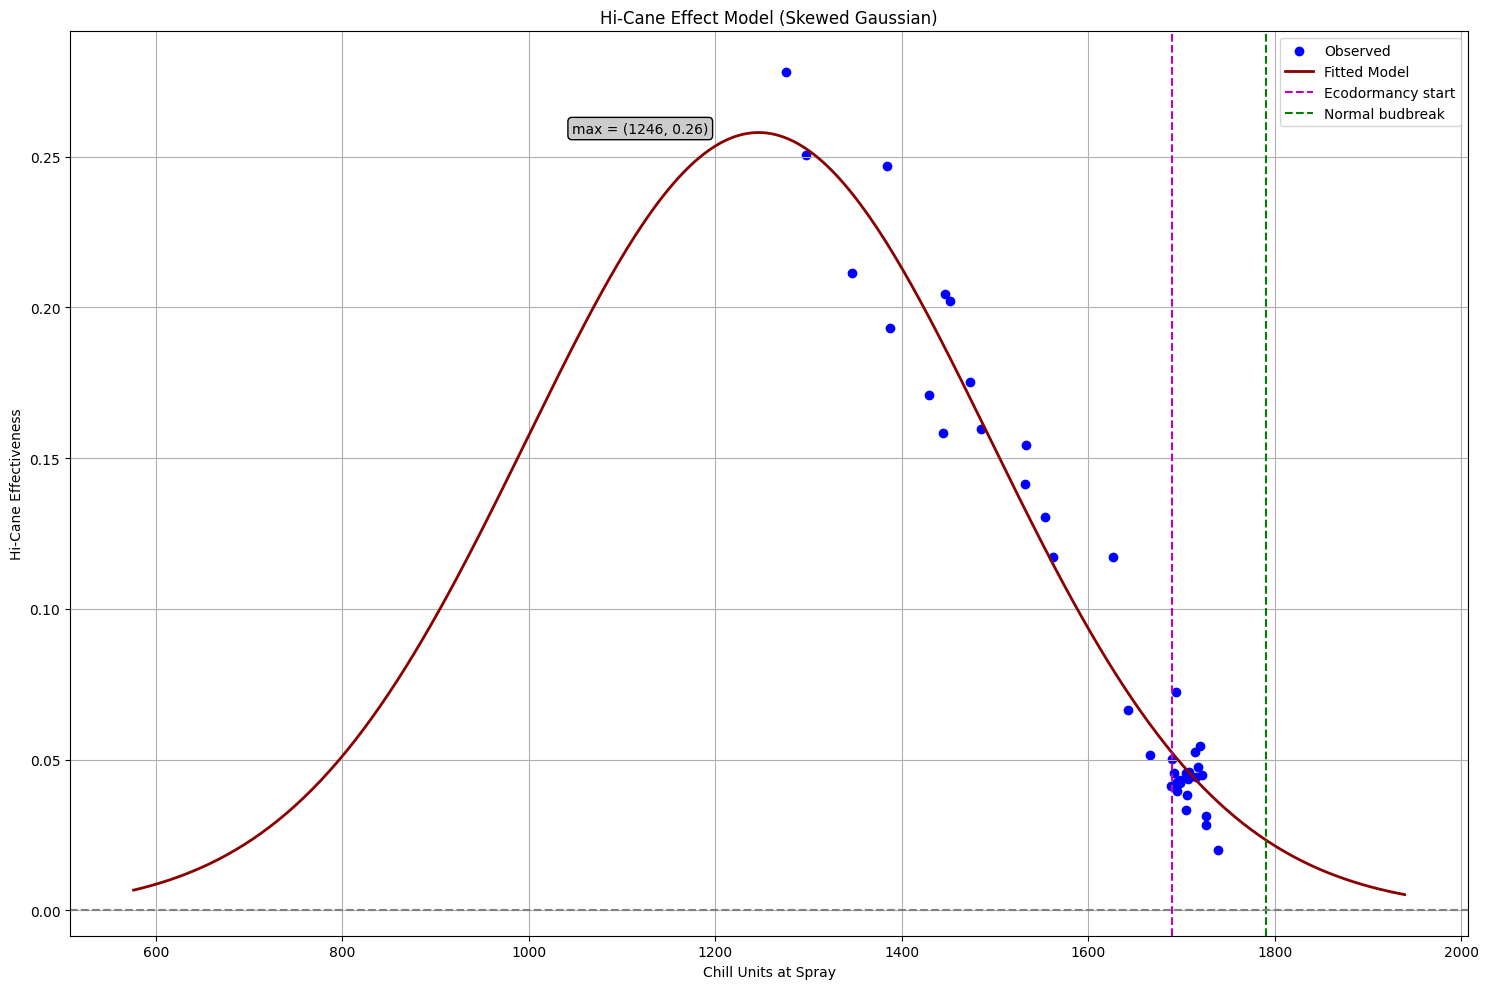

mu: 1246.25
A: 0.65
sigma: 248.19
alpha: 0.00


In [395]:
def skewed_gaussian(x, mu, A, sigma, alpha):
    """
    Skewed Gaussian: combines a normal PDF and CDF
    """
    norm_pdf = norm.pdf((x - mu) / sigma)
    norm_cdf = norm.cdf(alpha * (x - mu) / sigma)
    return A * 2 * norm_pdf * norm_cdf


# Filter data to remove post endo-dormancy HC applications
# filter_post_endo = (chu_spray <= chill_requirement)

chu_spray = np.array(chu_spray)

chu_obs = np.array(chu_obs)

x = chu_spray
y = (np.array(chu_obs)-(chu_spray))/chu_spray

# Initial guess: [mu, A, sigma, alpha]
p0 = [1300, 0.5, 100, 0]

# Parameter bounds to help constrain and ensure both phases get fit
bounds = (
    [800, 0, 50, 0],  # Lower bounds
    [1400, 1, 300, 0.001]  # Upper bounds
)

# Fit the model
popt, _ = curve_fit(skewed_gaussian, x, y, p0=p0, bounds=bounds, maxfev=10000)

# Generate fit curve
x_fit = np.linspace(min(x)-700, max(x)+200, 300)
y_fit = skewed_gaussian(x_fit, *popt)

# Plot results
plt.figure(figsize=(15, 10))
plt.scatter(x, y, label="Observed", color="blue")
plt.plot(x_fit, y_fit, label="Fitted Model", color="darkred", linewidth=2)
plt.axvline(chill_requirement, linestyle='--', color='m', label="Ecodormancy start")
plt.axvline(normal_budbreak, linestyle='--', color='green', label="Normal budbreak")
plt.axhline(0, linestyle='--', color='gray')
# plt.axvline(1383, linestyle='--', color='c', label="HWBBRawTP2021HiCane214")
# plt.axvline(1629, linestyle='--', color='c', label="KKHaywardBB2013HC246")
# plt.axvline(1704, linestyle='--', color='c', label="KatoaBB2008HC240")
# plt.axvline(1689.45, linestyle='--', color='c', label="KatoaBB2010HC231")
plt.xlabel("Chill Units at Spray")
plt.ylabel("Hi-Cane Effectiveness")
plt.title("Hi-Cane Effect Model (Skewed Gaussian)")
bbox = dict(boxstyle="round", fc="0.8")
plt.annotate(
    f'max = ({x_fit[np.argmax(y_fit)]:.0f}, {np.max(y_fit):.2f})',
    xy=(popt[0]-200, np.max(y_fit)), 
    bbox=bbox)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print fitted parameter values
param_names = ["mu", "A", "sigma", "alpha"]
for name, val in zip(param_names, popt):
    print(f"{name}: {val:.2f}")



In [ ]:
locations = ['Te Puke', 'Kerikeri']
chill_start_day = pd.to_datetime(utils.base_model_config()['StartDay']).day_of_year 
ideal_units_gaussian = popt[0]
max_effect_gaussian = popt[1]
tolerance_gaussian = popt[2]
skew_gaussian = popt[3]

predicted_budbreak_doy = defaultdict(lambda: defaultdict(lambda: defaultdict()))
natural_budbreak_doy = defaultdict(lambda: defaultdict(lambda: defaultdict()))

for i, location in enumerate(locations):
    start_day = int(round(chill_start_day))
    for year, sheet_info in weather_df[location].items(): 
        for sheet_info, weather_data in weather_df[location][year].items():
            weather_since_start_doy = weather_data[weather_data['doy']>=start_day].reset_index(drop=True)  
            
            Acc_unit_spray = CHU_spray[location][year][sheet_info]

            proportion_unit_spray = skewed_gaussian(Acc_unit_spray, ideal_units_gaussian, max_effect_gaussian,tolerance_gaussian,skew_gaussian)
            effective_target = Acc_unit_spray * ( 1 + proportion_unit_spray)

            if Acc_unit_spray < base_model_config['ChillRequirement']:
                effective_chill_target = effective_target * 0.9640
                effective_heat_target = effective_target - effective_chill_target
                print(sheet_info,Acc_unit_spray, effective_chill_targetو effective_heat_target)
            else:
                effective_chill_target = base_model_config['ChillRequirement']
                effective_heat_target = effective_target - base_model_config['ChillRequirement']
            
            
            predicted_doy = budbreak_prediction(weather_since_start_doy, effective_chill_target, effective_heat_target)
            predicted_budbreak_doy[location][year][sheet_info] = predicted_doy


def observ_predict_plot(predicted_budbreak_doy, observed_budbreak_doy, CHU_spray,  regression_xy=False):
    fig = go.Figure()

    observations = []
    predictions = []
    all_bb_days = []
    for loc in observed_budbreak_doy.keys():
        for year in observed_budbreak_doy[loc].keys():
            for sheet_info in observed_budbreak_doy[loc][year]:

                # if CHU_spray[loc][year][sheet_info] > base_model_config['ChillRequirement']:

                observed_bb = observed_budbreak_doy[loc][year][sheet_info]
                predicted_bb = predicted_budbreak_doy[loc][year][sheet_info]

                observations.append(observed_bb)
                predictions.append(predicted_bb)

                all_bb_days.append(observed_bb)
                all_bb_days.append(predicted_bb)

                fig.add_trace(go.Scatter(x=[observed_bb], y=[predicted_bb], mode='markers', marker=dict(size=15), name=sheet_info))

    mae = round(utils.mean_absolute_error(observations,predictions),2)
    rmse = round(root_mean_squared_error(observations,predictions),2)


    # Add 1:1 dashed line
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=[min(all_bb_days), max(all_bb_days)], mode='lines', line=dict(color="white", dash="dash"), name="1:1 Line")) 

    # Calculate std of observations to compare with MAE
    obs_std = round(np.std(observations),2)
    # ±MAE bands
    upper_line_mae = np.array([min(all_bb_days), max(all_bb_days)]) + np.array(mae)   
    lower_line_mae = np.array([min(all_bb_days), max(all_bb_days)]) - np.array(mae)  
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=upper_line_mae, mode='lines', line=dict(color="grey", dash="dot"), name='+MAE'))
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=lower_line_mae, mode='lines', line=dict(color="grey", dash="dot"), name='-MAE'))  
    # RMSE bands: If RMSE bands are much wider than MAE bands, it means there are large outliers affecting the model's performance.
    upper_line_rmse = np.array([min(all_bb_days), max(all_bb_days)]) + np.array(mae)   
    lower_line_rmse = np.array([min(all_bb_days), max(all_bb_days)]) - np.array(mae)  
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=upper_line_rmse, mode='lines', line=dict(color="yellow", dash="dot"), name='+RMSE'))
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=lower_line_rmse, mode='lines', line=dict(color="yellow", dash="dot"), name='-RMSE'))  

    # Plot regression line
    if regression_xy is not False:
        fig.add_trace(go.Scatter(x=regression_xy[0], y=regression_xy[1], mode='lines', line=dict(color="white", dash="solid"), name=f"Regression"))

    # Update layout
    fig.update_layout(
        title= f"BudBurst (MAE = {mae}, RMSE = {rmse}, ObsSTD = {obs_std})",
        xaxis_title="Observed BudBurst DOY",
        yaxis_title="Predicted BudBurst DOY",
        template="plotly_dark", width=1600, height=1400)
    fig.show()

observ_predict_plot(predicted_budbreak_doy, observed_budbreak_doy, CHU_spray)

            

HW-BudbreakTP2020HiCane223 1642.934109627011 1761.139326328794
HW-Budbreak-TP2020HiCane226 1688.613790735482 1777.6262400797787
HWBBRawTP2021HiCane214 1383.5707477009692 1689.8941753850972
HWBBRawTP2021HiCane223 1532.139828533404 1735.7842059300217
HWBBRawTP2021HiCane232 1666.203803691224 1768.9494795087066
NBB2010HC236 1446.090500121897 1715.916941453828
NBB2011HC248 1484.9127687006344 1726.2309521992513
KKHaywardBB2013HC246 1626.485577453018 1756.2962228888557
KKHaywardBB2013HC239 1533.2926876994363 1736.000751220522
KKHaywardBB2018HiCane 6% + 0.2% Driftstop239 1452.055959077086 1717.7266798677817
KKHaywardBB2018HiCane 6% + 0.2% Driftstop248 1553.6791703949934 1739.8412953741783
HaywardBB2019HC 6% + 0.2%DS236 1472.8323256258795 1723.3576130824652
HaywardBB2019HC 6% + 0.2%DS243 1561.7865979276082 1741.4045617803326
HWBBRaw2020HiCane+Driftstop240 1346.1135407095842 1666.4220419024334
HWBBRaw2020HiCane+Driftstop235 1297.6229743651843 1625.3210043999657
HWBBRaw2020HiCane+Driftstop247 142

array([ 600.        ,  744.44444444,  888.88888889, 1033.33333333,
       1177.77777778, 1322.22222222, 1466.66666667, 1611.11111111,
       1755.55555556, 1900.        ])

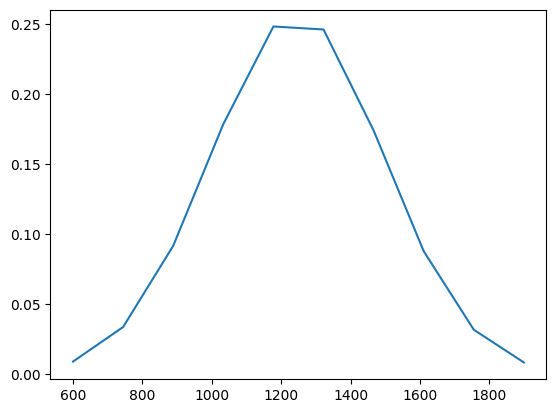

In [411]:
points = np.linspace(600,1900,10)

outputs = skewed_gaussian(points, *popt) 

plt.plot(points,outputs)

points

In [407]:
CHU_spray

defaultdict(<function __main__.<lambda>()>,
            {'Te Puke': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {2016: {'TPROB4BB2016HiCane236': 1689.6391358355734,
                           'TPROB4BB2016HiCane246': 1714.2909277289211},
                          2008: {'KatoaBB2008HC240': 1704.627091745503,
                           'MeadBB2008HC241': 1705.9028462932263},
                          2009: {'KatoaBB2009HC234': 1725.655870740192,
                           'KatoaBB2009HC240': 1739.2176439785478,
                           'MeadBB2009HC234': 1725.655870740192},
                          2010: {'KatoaBB2010HC231': 1698.4823942370865,
                           'MeadBB2010HC236': 1706.4929604037306},
                          2013: {'TPHaywardBB2013HC236': 1707.3116233188302,
                           'TPHaywardBB2013HC227': 1691.6074714754766,
                           'TPHaywardBB2013HC242': 1719.9477110938883},
               

In [450]:
pd.to_datetime('2020-08-30').day_of_year

243